In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from src.data_utils import LoadDataset, SavePath
from src.config import TrainConfig

In [ ]:
args = TrainConfig( base_path,              # project directory path
                    n_epochs = 200,         # number of epochs to train (default: 100)
                    batch_size = 128,       # input batch size for training (default: 128)
                    lr = 0.0002,            # learning rate (default: 0.0001)
                    dim_h = 128,            # hidden dimension (default: 128)')
                    n_z = 8,                # hidden dimension of z (default: 8)
                    LAMBDA = 10,            # regularization coef term (default: 10)
                    sigma = 1,              # variance of hidden dimension (default: 1)
                    n_channel = 1,          # input channels (default: 1)
                    img_size = 28 )         # image size

In [ ]:
def unfreeze_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = True

def freeze_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = False

In [ ]:
def save_models(model_path, epoch_no):
    print("Saving models")
    torch.save(conv_encoder.state_dict(), model_path + "/conv_encoder_" + "%d.pth" % epoch_no)
    torch.save(conv_decoder.state_dict(), model_path + "/conv_decoder_" + "%d.pth" % epoch_no)
    torch.save(linear_encoder.state_dict(), model_path + "/linear_encoder_" + "%d.pth" % epoch_no)
    torch.save(linear_decoder.state_dict(), model_path + "/linear_decoder_" + "%d.pth" % epoch_no)
    torch.save(discriminator.state_dict(), model_path + "/discriminator_" + "%d.pth" % epoch_no)

def save_lists(list_path, epoch_no, reconstr_loss):
    print("Saving list")
    if reconstr_loss:
        np.savetxt(list_path + '/reconstr_loss_' + '%d.txt'% epoch_no, reconstr_loss)

In [ ]:
sp = SavePath(args, checkpoint_path="/content/drive/My Drive/UC Davis Synthetic Data/Prashanth's/Autoencoder/Autoencoder/outs/Fri-Oct-30-16-43-47-2020/")
# sp = SavePath(args)

/content/drive/My Drive/UC Davis Synthetic Data/Prashanth's/Autoencoder/Autoencoder/outs/Fri-Oct-30-16-43-47-2020/


In [ ]:
# The output of torchvision datasets are PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,))])

transform1 = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,))])

cdl = LoadDataset(args, data='mnist', transform=None)
train_loader = cdl.get_data_loader(train=True)
test_loader = cdl.get_data_loader(train=False)

cdl_norm = LoadDataset(args, data='mnist', transform=transform)
train_loader_norm = cdl_norm.get_data_loader(train=True)
test_loader_norm = cdl_norm.get_data_loader(train=False)

cdl_norm1 = LoadDataset(args, data='mnist', transform=transform1)
train_loader_norm1 = cdl_norm1.get_data_loader(train=True)
test_loader_norm1 = cdl_norm1.get_data_loader(train=False)

In [ ]:
class LinearEncoder:

    def __init__(self, args):

        self.model = self.Model(args)
        if torch.cuda.is_available():
            self.model = self.model.cuda()


    class Model(nn.Module):

        def __init__(self, args):
            super(LinearEncoder, self).__init__()
            
            self.n_z = args.n_z
            self.dim_h = args.dim_h
            self.dim_input = (args.img_size ** 2)

            self.num_layers = 1

            self.main = nn.ModuleList([nn.Linear(self.dim_input, self.n_z)])
                

        def forward(self, x):
            for i, l in enumerate(self.main):
                x = self.main[i](x)
            return x

    
    
    def build_example_model(self, width):
            # check if width is a power of 2
            if width < 1 or (width & (width - 1)) != 0:
                raise Exception("width must be a power of 2")
            hidden_layers = OrderedDict()
            layer_no = 1
            linear_layer_name, relu_layer_name = 'linear_{}'.format(layer_no), 'relu_{}'.format(layer_no)
            hidden_layers[linear_layer_name] = nn.Linear(self.dim_input, self.dim_h * width)
            hidden_layers[relu_layer_name] = nn.ReLU(True)
            layer_no += 1
            while width // 2 > 0:
                linear_layer_name, relu_layer_name = 'linear_{}'.format(layer_no), 'relu_{}'.format(layer_no)
                hidden_layers[linear_layer_name] = nn.Linear(self.dim_h * width, self.dim_h * (width // 2))
                hidden_layers[relu_layer_name] = nn.ReLU(True)
                layer_no += 1
                width = width // 2
            linear_layer_name = 'linear_{}'.format(layer_no)
            hidden_layers[linear_layer_name] = nn.Linear(self.dim_h, self.n_z)

            self.main = nn.Sequential(hidden_layers)

In [ ]:
enc = LinearEncoder(args).cuda()

In [ ]:
summary(enc, (1,784))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1, 8]           6,280
Total params: 6,280
Trainable params: 6,280
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


In [ ]:
enc.cuda()

In [ ]:
summary(enc, (1,784))

In [ ]:
class LinearEncoder(nn.Module):

    def __init__(self, args):
        super(LinearEncoder, self).__init__()
        
        self.n_z = args.n_z
        self.dim_h = args.dim_h
        self.dim_input = args.img_size ** 2

        self.main = nn.Sequential(
            nn.Linear(self.dim_input, self.dim_h * 16),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 16, self.dim_h * 8),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 8, self.dim_h * 8),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 8, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, self.dim_h * 2),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 2, self.dim_h),
            nn.ReLU(True),
            nn.Linear(self.dim_h, self.n_z)
        )
    
    def forward(self, x):
        x = self.main(x)
        return x

In [ ]:
class LinearDecoder(nn.Module):

    def __init__(self, args):
        super(LinearDecoder, self).__init__()

        self.n_z = args.n_z
        self.dim_h = args.dim_h
        self.dim_output = args.img_size ** 2

        self.main = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h),
            nn.ReLU(True),
            nn.Linear(self.dim_h, self.dim_h * 2),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 2, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, self.dim_h * 8),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 8, self.dim_h * 8),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 8, self.dim_h * 16),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 16, self.dim_output),
            # nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.main(x)
        return x

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, args):
        super(Discriminator, self).__init__()

        self.dim_h = args.dim_h
        self.n_z = args.n_z

        self.main = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.main(x)
        return x

In [ ]:
linear_encoder, linear_decoder = LinearEncoder(args).cuda(), LinearDecoder(args).cuda()
discriminator = Discriminator(args).cuda()

criterion = nn.MSELoss()

# Optimizers
optim_encoder = optim.Adam(linear_encoder.parameters(), lr=args.lr)
optim_decoder = optim.Adam(linear_decoder.parameters(), lr=args.lr)
optim_discriminator = optim.Adam(discriminator.parameters(), lr = 0.5*args.lr)

In [ ]:
summary(discriminator, (1, 8))
summary(linear_decoder, (1, 8))
summary(linear_encoder, (1, 784))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 512]           4,608
              ReLU-2               [-1, 1, 512]               0
            Linear-3               [-1, 1, 512]         262,656
              ReLU-4               [-1, 1, 512]               0
            Linear-5               [-1, 1, 512]         262,656
              ReLU-6               [-1, 1, 512]               0
            Linear-7               [-1, 1, 512]         262,656
              ReLU-8               [-1, 1, 512]               0
            Linear-9               [-1, 1, 512]         262,656
             ReLU-10               [-1, 1, 512]               0
           Linear-11                 [-1, 1, 1]             513
          Sigmoid-12                 [-1, 1, 1]               0
Total params: 1,055,745
Trainable params: 1,055,745
Non-trainable params: 0
---------------------------

In [ ]:
checkpoint = 150
reconstr_loss_epoch = []
if checkpoint:
    _, list_path, model_path = sp.get_save_paths()
    linear_encoder.load_state_dict(torch.load(model_path + "/linear_encoder_{}.pth".format(checkpoint)))
    # conv_encoder.load_state_dict(torch.load(model_path + "/conv_encoder_{}.pth".format(checkpoint)))
    linear_decoder.load_state_dict(torch.load(model_path + "/linear_decoder_{}.pth".format(checkpoint)))
    # conv_decoder.load_state_dict(torch.load(model_path + "/conv_decoder_{}.pth".format(checkpoint)))
    discriminator.load_state_dict(torch.load(model_path + "/discriminator_{}.pth".format(checkpoint)))
    # reconstr_loss_epoch = np.loadtxt(list_path + '/reconstr_loss_{}.txt'.format(checkpoint)).tolist()
reconstr_loss = []
disc_loss = []
d_real_val = []

In [ ]:
image_path, list_path, model_path = sp.get_save_paths()

In [ ]:
for epoch in range(checkpoint, checkpoint+args.n_epochs):
    for step, (images, _) in tq(enumerate(train_loader)):

        images = images.cuda()
        images_flattened = images.reshape([images.size()[0], 1, args.img_size**2])
        images_dct = dct.dct(images_flattened, norm='ortho')
        
        linear_encoder.zero_grad()
        linear_decoder.zero_grad()
        discriminator.zero_grad()

        # ======== Train Discriminator ======== #

        unfreeze_params(discriminator)
        freeze_params(linear_encoder)
        freeze_params(linear_decoder)

        z_dist = torch.randn(images.size()[0], args.n_z) * args.sigma
        z_dist = z_dist.cuda().detach()

        z_linear = linear_encoder(images_dct).detach()

        d_dist = discriminator(z_dist)
        d_linear = discriminator(z_linear).detach()
        
        # d_loss = ((d_dist.mean()) + ((1 - d_linear).mean()))
        d_loss = -(torch.log(d_dist.mean()) + torch.log((1 - d_linear).mean()))

        disc_loss.append([d_dist.mean().item(), d_linear.mean().item(), d_loss.item()])

        d_loss.backward()

        optim_discrtiminator.step()

        # ======== Train Generator ======== #
        
        freeze_params(discriminator)
        unfreeze_params(linear_encoder)
        unfreeze_params(linear_decoder)

        z_linear_real = linear_encoder(images_dct)
        recon_linear = linear_decoder(z_linear_real)
        d_linear_real = discriminator(z_linear_real)
        
        recon_loss = criterion(recon_linear, images_dct)
        reg_loss = -(args.LAMBDA * torch.log(d_linear_real).mean())

        total_loss = recon_loss + reg_loss

        total_loss.backward()

        d_real_val.append(reg_loss.item())

        optim_encoder.step()
        optim_decoder.step()
        
        reconstr_loss.append(recon_loss.data.item())

    if (epoch + 1) % 1 == 0:
        temp = np.mean(disc_loss, axis=0)
        print("Epoch: [%d/%d], Recon Loss: [%.4f], reg loss: [%.4f], d_loss: [%.4f], d_dist: [%.4f], d_linear: [%.4f]" %
                (epoch + 1, args.n_epochs, np.mean(reconstr_loss), np.mean(d_real_val), temp[2], temp[0], temp[1]))
        reconstr_loss.clear()
        disc_loss.clear()
        d_real_val.clear()
    
    if (epoch + 1) % 1 == 0:

        batch_size = args.batch_size // 2
        test_iter = iter(test_loader)
        test_images, _ = next(test_iter)
        test_images = Variable(test_images)[:64]
        
        test_images_flattened = test_images[:64].reshape([batch_size, 1, args.img_size**2])
        test_images_dct = dct.dct(test_images_flattened, norm='ortho')

        z_linear = linear_encoder(test_images_dct.cuda()).detach()
        z_dist = torch.randn_like(z_linear).cuda()

        recon_linear = dct.idct(linear_decoder(z_linear), norm='ortho')
        z_linear_sample = dct.idct(linear_decoder(z_dist), norm='ortho')

        linear_sample = make_grid(z_linear_sample.detach().cpu().view(batch_size, 1, 28, 28))
 
        # scale = 1.0 / (recon_linear.max(dim=2, keepdim=True)[0] - recon_linear.min(dim=2, keepdim=True)[0])
        # recon_linear_normalized = recon_linear.mul_(scale).sub_(recon_linear.min(dim=2, keepdim=True)[0])

        image = torch.cat((test_images.view(batch_size, 1, 28, 28), 
                           recon_linear.cpu().view(batch_size, 1, 28, 28).data,
                           ), axis=3)
        
        save_image(image, image_path +
                                '/inputs_reconstr_{}.png'.format(epoch+1), normalize=False, pad_value=1, scale_each=False)
        
        save_image(linear_sample, image_path + 
                                '/sample_{}.png'.format(epoch+1), normalize=False, pad_value=1)

    if (epoch + 1) % 25 == 0:
        save_models(model_path, epoch+1)


Epoch: [151/200], Recon Loss: [0.0164], reg loss: [6.9409], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [152/200], Recon Loss: [0.0163], reg loss: [6.9409], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [153/200], Recon Loss: [0.0162], reg loss: [6.9409], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [154/200], Recon Loss: [0.0163], reg loss: [6.9409], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [155/200], Recon Loss: [0.0162], reg loss: [6.9409], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [156/200], Recon Loss: [0.0161], reg loss: [6.9409], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [157/200], Recon Loss: [0.0160], reg loss: [6.9409], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [158/200], Recon Loss: [0.0160], reg loss: [6.9409], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [159/200], Recon Loss: [0.0160], reg loss: [6.9409], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [160/200], Recon Loss: [0.0160], reg loss: [6.9409], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [161/200], Recon Loss: [0.0160], reg loss: [6.9409], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [162/200], Recon Loss: [0.0159], reg loss: [6.9409], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [163/200], Recon Loss: [0.0159], reg loss: [6.9409], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [164/200], Recon Loss: [0.0159], reg loss: [6.9409], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [165/200], Recon Loss: [0.0158], reg loss: [6.9409], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [166/200], Recon Loss: [0.0158], reg loss: [6.9409], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [167/200], Recon Loss: [0.0157], reg loss: [6.9409], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [168/200], Recon Loss: [0.0157], reg loss: [6.9409], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [169/200], Recon Loss: [0.0157], reg loss: [6.9409], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [170/200], Recon Loss: [0.0157], reg loss: [6.9409], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [171/200], Recon Loss: [0.0156], reg loss: [6.9409], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [172/200], Recon Loss: [0.0156], reg loss: [6.9409], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [173/200], Recon Loss: [0.0155], reg loss: [6.9409], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [174/200], Recon Loss: [0.0155], reg loss: [6.9409], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [175/200], Recon Loss: [0.0154], reg loss: [6.9409], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]
Saving models



Epoch: [176/200], Recon Loss: [0.0154], reg loss: [6.9409], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [177/200], Recon Loss: [0.0154], reg loss: [6.9409], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [178/200], Recon Loss: [0.0153], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [179/200], Recon Loss: [0.0153], reg loss: [6.9409], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [180/200], Recon Loss: [0.0153], reg loss: [6.9409], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [181/200], Recon Loss: [0.0152], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [182/200], Recon Loss: [0.0152], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [183/200], Recon Loss: [0.0152], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [184/200], Recon Loss: [0.0152], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [185/200], Recon Loss: [0.0151], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [186/200], Recon Loss: [0.0151], reg loss: [6.9409], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [187/200], Recon Loss: [0.0151], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [188/200], Recon Loss: [0.0150], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [189/200], Recon Loss: [0.0150], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [190/200], Recon Loss: [0.0150], reg loss: [6.9409], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [191/200], Recon Loss: [0.0150], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [192/200], Recon Loss: [0.0149], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [193/200], Recon Loss: [0.0148], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [194/200], Recon Loss: [0.0148], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [195/200], Recon Loss: [0.0148], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [196/200], Recon Loss: [0.0148], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [197/200], Recon Loss: [0.0148], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [198/200], Recon Loss: [0.0147], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [199/200], Recon Loss: [0.0147], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [200/200], Recon Loss: [0.0148], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]
Saving models



Epoch: [201/200], Recon Loss: [0.0146], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [202/200], Recon Loss: [0.0147], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [203/200], Recon Loss: [0.0146], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [204/200], Recon Loss: [0.0146], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [205/200], Recon Loss: [0.0145], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [206/200], Recon Loss: [0.0145], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [207/200], Recon Loss: [0.0144], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [208/200], Recon Loss: [0.0145], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [209/200], Recon Loss: [0.0144], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [210/200], Recon Loss: [0.0144], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [211/200], Recon Loss: [0.0143], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [212/200], Recon Loss: [0.0143], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [213/200], Recon Loss: [0.0143], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [214/200], Recon Loss: [0.0143], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [215/200], Recon Loss: [0.0142], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [216/200], Recon Loss: [0.0144], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [217/200], Recon Loss: [0.0142], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [218/200], Recon Loss: [0.0142], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [219/200], Recon Loss: [0.0142], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [220/200], Recon Loss: [0.0141], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [221/200], Recon Loss: [0.0141], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [222/200], Recon Loss: [0.0142], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [223/200], Recon Loss: [0.0141], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [224/200], Recon Loss: [0.0141], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [225/200], Recon Loss: [0.0140], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]
Saving models



Epoch: [226/200], Recon Loss: [0.0140], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [227/200], Recon Loss: [0.0140], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [228/200], Recon Loss: [0.0140], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [229/200], Recon Loss: [0.0140], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [230/200], Recon Loss: [0.0141], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [231/200], Recon Loss: [0.0140], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [232/200], Recon Loss: [0.0139], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [233/200], Recon Loss: [0.0139], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [234/200], Recon Loss: [0.0140], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [235/200], Recon Loss: [0.0139], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [236/200], Recon Loss: [0.0139], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [237/200], Recon Loss: [0.0138], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [238/200], Recon Loss: [0.0139], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [239/200], Recon Loss: [0.0139], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [240/200], Recon Loss: [0.0139], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [241/200], Recon Loss: [0.0138], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [242/200], Recon Loss: [0.0138], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [243/200], Recon Loss: [0.0138], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [244/200], Recon Loss: [0.0139], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [245/200], Recon Loss: [0.0139], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [246/200], Recon Loss: [0.0138], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [247/200], Recon Loss: [0.0138], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]



Epoch: [248/200], Recon Loss: [0.0137], reg loss: [6.9408], d_loss: [1.3938], d_dist: [0.4958], d_linear: [0.4995]


KeyboardInterrupt: ignored

In [ ]:
train_iter = iter(train_loader)
images, labels = next(train_iter)
print(labels[0])
shape = images.size()
images = images.reshape([shape[0], shape[1], shape[2]*shape[3]])

tensor(4)


In [ ]:
pixel = 430
print(images_ifft.shape)
print(images[0][0][pixel], images_fft[0][0][pixel], images_ifft[0][0][pixel])

torch.Size([128, 1, 784])
tensor([0.]) tensor([-0.0187,  0.0423]) tensor(-2.5824e-08)


In [ ]:
images_norm = (images.sub(torch.tensor(0.1307))).true_divide(torch.tensor(1))

In [ ]:
images_norm.std()

tensor(0.3045)

In [ ]:
images_dct = dct.dct(images, norm='ortho')
images_dct_norm = dct.dct(images_norm, norm='ortho')

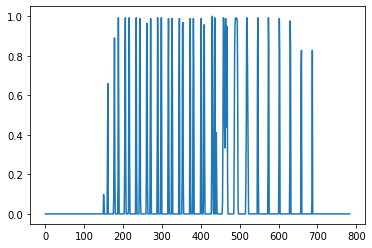

In [ ]:
i = 4
plt.plot(images[i].squeeze())

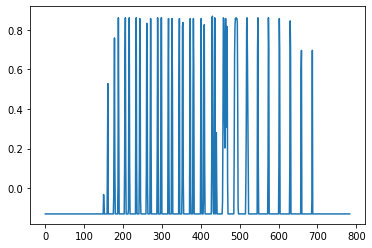

In [ ]:
plt.plot(images_norm[i].squeeze())

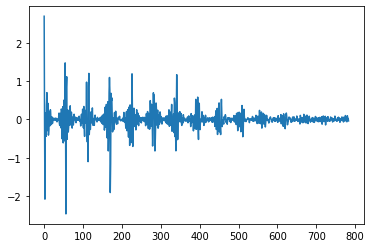

In [ ]:
plt.plot(images_dct[i].squeeze())

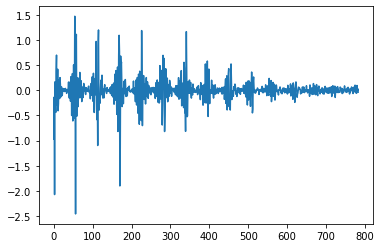

In [ ]:
plt.plot(images_dct_norm[i].squeeze())

In [ ]:
images.

In [ ]:
linear_encoder = linear_encoder.cpu()
linear_decoder = linear_decoder.cpu()

In [ ]:
images_encoding = linear_encoder(images_dct)

In [ ]:
images_recon = linear_decoder(images_encoding)

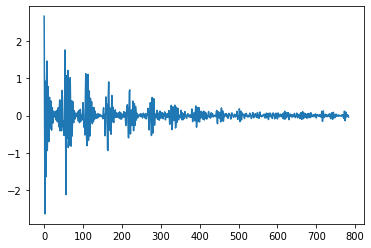

In [ ]:
plt.plot(images_dct[0].squeeze())

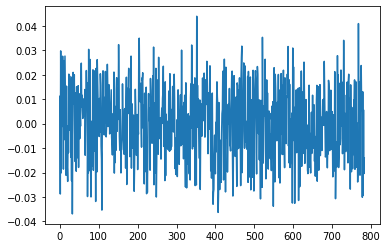

In [ ]:
plt.plot(images_recon[0].detach().squeeze())

In [ ]:
torch.norm(images[0])

tensor(10.3897)

In [ ]:
torch.norm(images_dct[0])

tensor(10.3897)

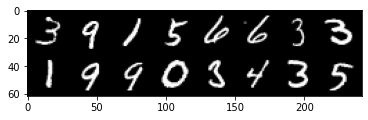

In [ ]:
plt.imshow(make_grid(images.reshape(128,1,28,28)[:16], normalize=True).permute(1,2,0))

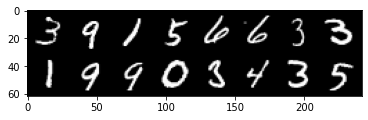

In [ ]:
plt.imshow(make_grid(dct.idct(images_dct_norm, norm='ortho').reshape(128,1,28,28)[:16], normalize=True).permute(1,2,0))

In [ ]:
tensor = images_fft.clone()
tmax, tmin = tensor.max(dim=2, keepdim=True)[0], tensor.min(dim=2, keepdim=True)[0]
scale = 1.0 / (tmax - tmin)
tensor_scaled = tensor.mul(scale)
tensor_scaled_centered = tensor_scaled.sub(tensor_scaled.min(dim=2, keepdim=True)[0])

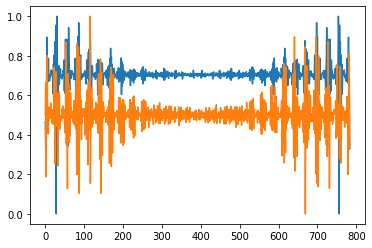

In [ ]:
plt.plot(tensor_scaled_centered[i].squeeze().cpu().numpy())

In [ ]:
tensor_scaled = tensor_scaled_centered.add(tensor_scaled.min(dim=2, keepdim=True)[0])
tensor_new = tensor_scaled.true_divide(scale)

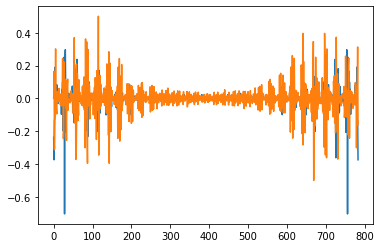

In [ ]:
plt.plot(tensor_scaled[i].squeeze().cpu().numpy())

In [ ]:
i = 0
images_real = images[:,:,:,0][i].squeeze().cpu().numpy()
images_fft_real = images_fft[:,:,:,0][i].squeeze().cpu().numpy()
images_fft_imaginary = images_fft[:,:,:,1][i].squeeze().cpu().numpy()
print(labels[i])

tensor(6)


In [ ]:
images_fft_real.max()

2.954127

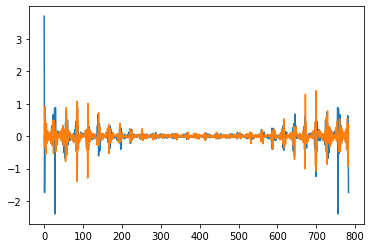

In [ ]:
plt.plot(images_fft[0].squeeze())

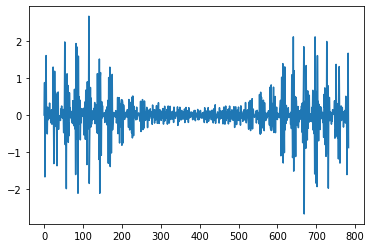

In [ ]:
plt.plot(images_fft_imaginary)

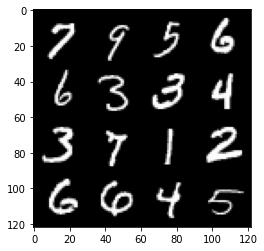

In [ ]:
img = make_grid(images.reshape([128,1,28,28])[:16], nrow=4)
plt.imshow(img.permute(1,2,0).cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


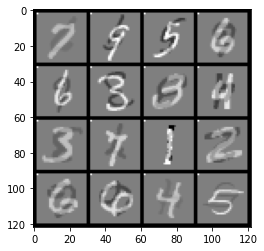

In [ ]:
img_ifft = tensor_scaled_centered.ifft(signal_ndim=1, normalized=True).sum(3)

img = make_grid(img_ifft.reshape([128,1,28,28])[:16] + 0.5, nrow=4, normalize=False)
plt.imshow(img.permute(1,2,0).cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


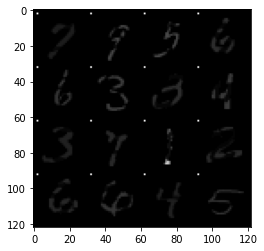

In [ ]:
approx_backscale = tensor_scaled_centered.mul(scale.mean(dim=0, keepdim=True))
img_ifft = approx_backscale.ifft(signal_ndim=1, normalized=True).sum(3)

img = make_grid(img_ifft.reshape([128,1,28,28])[:16], nrow=4, normalize=False)
plt.imshow(img.permute(1,2,0).cpu())